# Prédiction des retards de TGV
## Table des Matieres  <a class="anchor" id="table-des-matieres"></a>
1. [Sujet et objectifs](#sujet-et-objectifs)
2. [Importation des librairies](#importation-des-librairies)
3. [Chargement et exploration des données](#chargement-et-exploration-des-donnees)  
    - [Importation du fichier csv](#importation-du-fichier-csv)
    - [Informations elementaires du dataset](#infos-elemantaire-du-dataset)
    - [Reduction du jeu de donnees](#reduction-du-jeu-de-donnees)
4. [Analyse unidimensionnelle](#analyse-unidimensionnelle)
    - [Variables quantitatives](#variables-quantitatives)
    - [Variables catégorielles](#variables-categorielles)
5. [Analyse bidimensionnelle](#analyse-bidimensionnelle)
6. [Analyse temporelle](#analyse-temporelle)
7. [Prediction retard moyen arrivee](#prediction-retard-moyen-arrivee)
    - [Definition des fonctions de preprocessing](#definition-des-fonctions-de-preprocessing)
    - [Regression lineaire](#regression-lineaire)
        - [Sur tout le jeu de donnees](#sur-tout-le-de-donnees)
        - [Meilleur choix de colonnes](#meilleur-choix-de-colonnes)
        - [Relations polynomiales entre les colonnes](#relations-polynomiales-entre-les-colonnes)
        - [Avec PCA](#avec-pca)
    - [Modele lineaire](#modele-lineaire)
        - [Ridge](#ridge)
        - [Lasso](#lasso)
        - [Elastic Net](#elasctic-net)
        - [Bayesien ridge regression](#bayesien-ridge)
    - [Decision trees and random forest](#decision-trees-and-random-forest)
        - [Decision Tree](#Decision_Tree)
        - [Random Forest](#Random_Forest)
        - [Adaboost](#Adaboost)
8. [Prediction raison retard](#prediction-raison-retard)
    - [Linear regression](#linear-regression)
    - [Random forest](#random-forest)

## Sujet et objectifs <a class="anchor" id="sujet-et-objectifs"></a>
[Up](#table-des-matieres)
- La SNCF fournit mensuellement une synthèse de ses retards, les lignes concernées et les principales causes.  
- Le but de ce projet est de prédire pour les données de 2023 les durées moyennes de retard et les causes principales.  
- Il sera aussi attendu un rapport de 5 pages synthétisant les différentes approches qui ont été envisagées.  
  
## Importation des librairies <a class="anchor" id="importation-des-librairies"></a>
[Up](#table-des-matieres)

In [35]:
# Chargement, préparation et et visualisation du jeu de données
import numpy as np
import pandas as pd # permet de manipuler les dataframes
import seaborn as sns # permet de visualiser les principales infos du dataset
import matplotlib.pyplot as plt # permet d'afficher des graphiques
from mpl_toolkits.mplot3d import Axes3D

# Mise en forme des données pour les modèles de machine learning
from sklearn.pipeline import Pipeline # Permet de structurer le code de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid # Différentes fonction aidant aux choix des hyperparamètres
from sklearn.decomposition import PCA # composante principale
from sklearn.preprocessing import  LabelEncoder, StandardScaler, PolynomialFeatures # Manipulations des variables 
from sklearn.metrics import mean_squared_error, r2_score # Mesures des performances des modèles
from itertools import combinations # Relation entre les colonnes

# Modèles sklearn linéaire
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, LassoCV, ElasticNetCV # Modèle de régression linéaire et ses variantes
from sklearn.tree import DecisionTreeRegressor # Modèle arbre de décisions
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor # Modèle d'arbre de décisions pour la régression
from sklearn.svm import SVR # Support Vector Machine for regression

## Chargement et exploration des donnees <a class="anchor" id="chargement-et-exploration-des-donnees"></a>

### Importation du fichier csv <a class="anchor" id="importation-du-fichier-csv"></a>
[Up](#table-des-matieres)

In [2]:
data = pd.read_csv('regularite-mensuelle-tgv-aqst.csv',sep=";") #fichier avec un séparateur ; au lieu de ,

### Informations elemantaire du dataset <a class="anchor" id="infos-elemantaire-du-dataset"></a>
[Up](#table-des-matieres)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

- Ce dataframe contient 25 colonnes pour 8154 instances.  
- On trouve 3 types d'objets (object, int64 et float64)  
- On remarque que 3 colonnes contiennent des valeurs nulles : commentaire annulation, commentaire retard depart, commentaire retard arrivee. Les deux première ne contiennent aucune valeurs non nulles, on pourra donc les abandonnées par la suite.  
- D'après l'énoncé, ce que nous cherchons à prédire sont retard_moyen_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare.  
- Dans le contexte de notre modèle il ne semble pas pertinent de garder les autres valeurs de retard arrivee, en effet ces valeurs ne pourront pas être utilisés pour prédire un retard.  
- Notre dataframe peut donc être réduit aux colonnes 0 à 10; 12; 20 à 25

### Reduction du jeu de donnees <a class="anchor" id="reduction-du-jeu-de-donnees"></a>
[Up](#table-des-matieres)

In [4]:
data_1 = data.drop(['commentaire_annulation','commentaire_retards_depart','nb_train_retard_arrivee',
    'retard_moyen_tous_trains_arrivee','commentaires_retard_arrivee','nb_train_retard_sup_15','retard_moyen_trains_retard_sup15'
    ,'nb_train_retard_sup_30','nb_train_retard_sup_60'],axis=1)

print(data_1.head())
print(data_1.tail())

      date   service         gare_depart         gare_arrivee  duree_moyenne  \
0  2018-01  National    BORDEAUX ST JEAN   PARIS MONTPARNASSE            141   
1  2018-01  National   LA ROCHELLE VILLE   PARIS MONTPARNASSE            165   
2  2018-01  National  PARIS MONTPARNASSE              QUIMPER            220   
3  2018-01  National  PARIS MONTPARNASSE              ST MALO            156   
4  2018-01  National  PARIS MONTPARNASSE  ST PIERRE DES CORPS             61   

   nb_train_prevu  nb_annulation  nb_train_depart_retard  retard_moyen_depart  \
0             870              5                     289            11.247809   
1             222              0                       8             2.875000   
2             248              1                      37             9.501351   
3             102              0                      12            19.912500   
4             391              2                      61             7.796995   

   retard_moyen_tous_trains_depa

- On peut voir que la colonne date contient l'année et le mois, nous allons pouvoir séparer en deux colonnes year et month
- On peut voir que les colonnes gare de départ et gare d'arrivée sont composées de nombreuses valeurs différentes. Nous allons devoir nous assurer du nombre de valeur et vérifier s'il y a des nouvelles valeurs qui apparaissent au cours du temps.

In [5]:
# pour récupérer les colonnes year et month à partir de date, nous transformons d'abord au format datetime puis nous utilisons
# les méthodes afin de récupérer ces deux infos. Enfin nous supprimons la colonne date

data_2 = data_1.copy() #copie data_1 pour ne pas le modifier
data_2['date'] = pd.to_datetime(data_2['date'],format="%Y-%m") #convertit date au format datetime
data_2['year'] = data_2['date'].dt.year # extrait l'année
data_2['month'] = data_2['date'].dt.month # extrait le mois
data_2 = data_2[['year', 'month','date','service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'nb_train_depart_retard',
       'retard_moyen_depart', 'retard_moyen_tous_trains_depart',
       'retard_moyen_arrivee', 'prct_cause_externe', 'prct_cause_infra',
       'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',
       'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']] # change l'ordre des colonnes pour mettre dans un ordre logique

Maintenant que nous avons préparé le dataframe, nous allons approfondir notre analyse en cherchant à identifier l'importance des paramètres. Pour éviter de biaiser nos résultats, nous allons exclure les données de 2023.

In [6]:
data_train = data_2[data_2['year'] != 2023]
data_test = data_2[data_2['year'] == 2023]

## Analyse unidimensionnelle <a class="anchor" id="analyse-unidimensionnelle"></a>

### Variables quantitatives <a class="anchor" id="variables-quantitatives"></a>
[Up](#table-des-matieres)

In [7]:
data_train.describe()

year        month  duree_moyenne  nb_train_prevu  nb_annulation  \
count  7428.000000  7428.000000    7428.000000     7428.000000    7428.000000   
mean   2019.971325     6.503770     169.537157      252.838988      10.593700   
std       1.422420     3.451503      87.454109      171.523652      25.692063   
min    2018.000000     1.000000       0.000000        0.000000       0.000000   
25%    2019.000000     4.000000      99.000000      138.000000       0.000000   
50%    2020.000000     7.000000     163.000000      218.000000       2.000000   
75%    2021.000000    10.000000     221.000000      327.000000       9.000000   
max    2022.000000    12.000000     786.000000     1051.000000     288.000000   

       nb_train_depart_retard  retard_moyen_depart  \
count             7428.000000          7428.000000   
mean                89.388530            10.860356   
std                 91.538557            12.686470   
min                  0.000000             0.000000   
25%                 22.000000             4.827268   
50%                 56.000000             8.676902   
75%                130.000000            13.750296   
max                596.000000           316.188095   

       retard_moyen_tous_trains_depart  retard_moyen_arrivee  \
count                      7428.000000           7428.000000   
mean                          3.046966             33.411687   
std                           5.529474             15.248684   
min                        -229.269444            -40.109259   
25%                           1.098291             24.211179   
50%                           2.215148             31.995965   
75%                           3.859527             40.832860   
max                          84.516667            255.866667   

       prct_cause_externe  prct_cause_infra  prct_cause_gestion_trafic  \
count         7428.000000       7428.000000                7428.000000   
mean            23.560568         22.032626                  18.858527   
std             17.042406         15.946808                  14.913409   
min              0.000000          0.000000                   0.000000   
25%             11.864407         11.538462                   8.333333   
50%             21.294036         20.000000                  16.666667   
75%             33.333333         30.000000                  26.666667   
max            100.000000        100.000000                 100.000000   

       prct_cause_materiel_roulant  prct_cause_gestion_gare  \
count                  7428.000000              7428.000000   
mean                     18.803780                 6.546973   
std                      14.360738                 8.082902   
min                       0.000000                 0.000000   
25%                       9.090909                 0.000000   
50%                      16.666667                 4.878049   
75%                      25.806452                 9.725295   
max                     100.000000               100.000000   

       prct_cause_prise_en_charge_voyageurs  
count                           7428.000000  
mean                               6.979970  
std                               10.412434  
min                                0.000000  
25%                                0.000000  
50%                                3.333333  
75%                                9.859155  
max                              100.000000

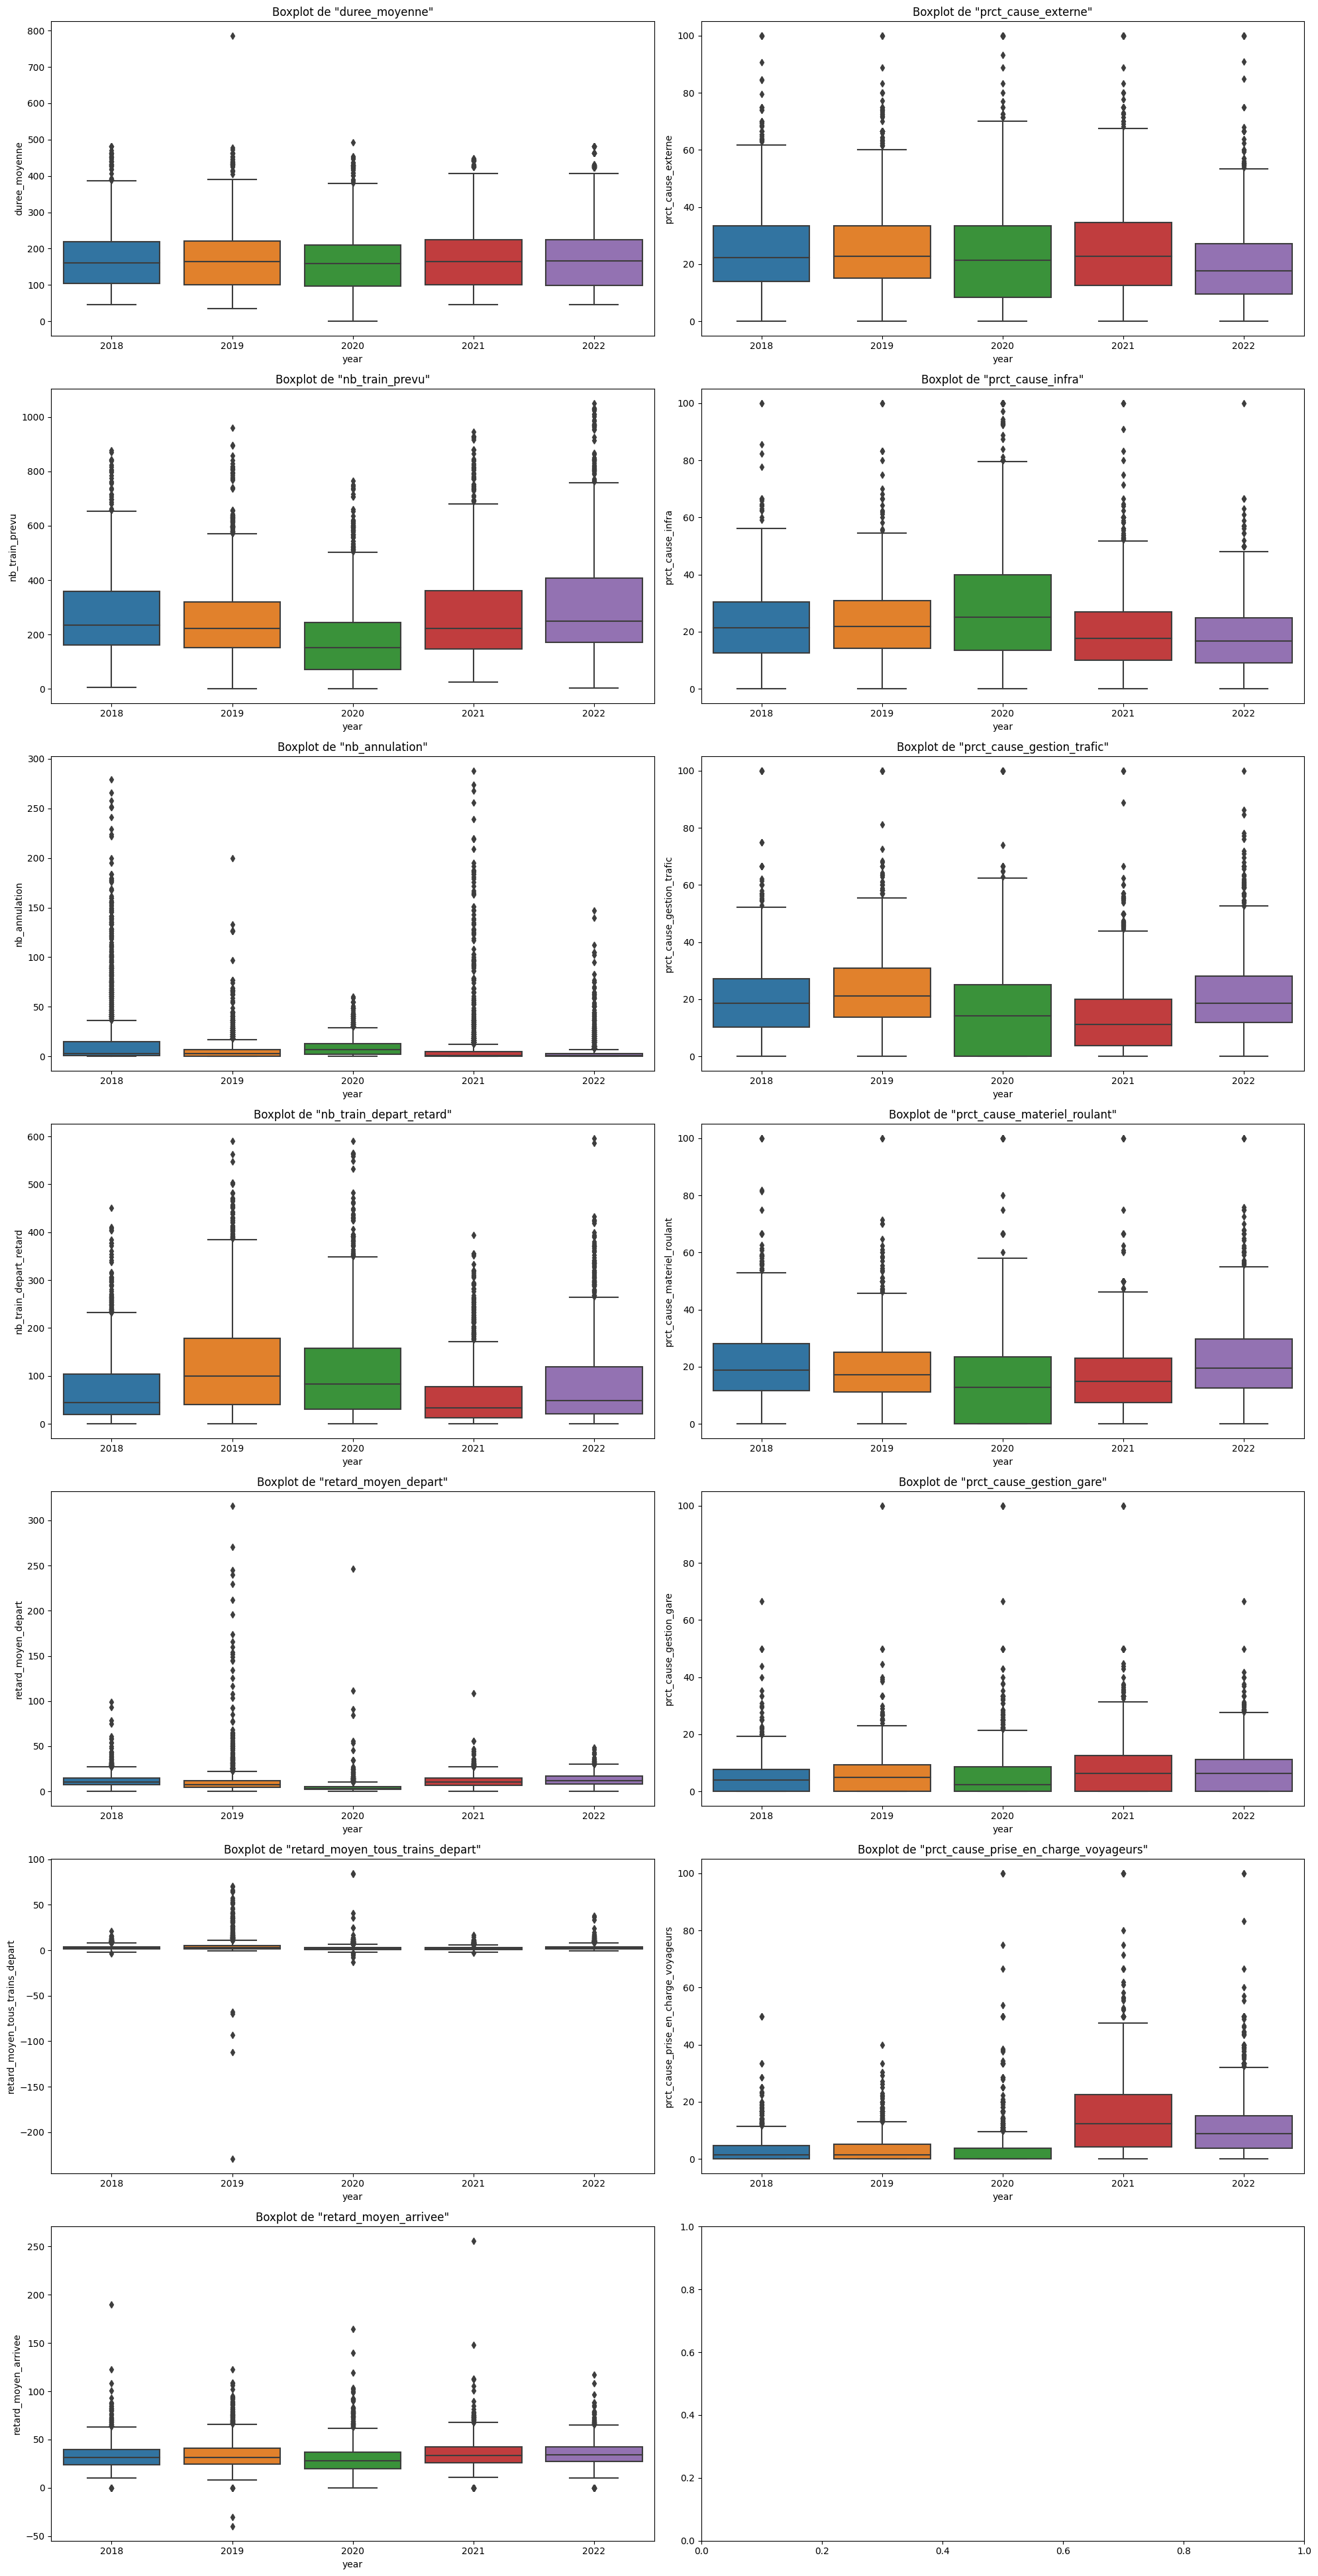

In [8]:
variables = ['duree_moyenne', 'nb_train_prevu', 'nb_annulation',
             'nb_train_depart_retard', 'retard_moyen_depart',
             'retard_moyen_tous_trains_depart', 'retard_moyen_arrivee',
             'prct_cause_externe', 'prct_cause_infra',
             'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',
             'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']

# on crée un tableau de sous-graphiques avec 7 lignes et 2 colonnes
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 3 * len(variables)))

# on parcourt les variables et on crée un diagramme boxplot pour chacune d'elles
for i, var in enumerate(variables):
    if i<7:
        ax = axes[i%7,0]
    else :
        ax = axes[i%7,1]
    sns.boxplot(data=data_train, x='year', y=var, ax=ax)
    ax.set_title(f'Boxplot de "{var}"')

# on règle l'espacement entre les sous-graphiques
plt.tight_layout()

# on affiche le tableau de sous-graphiques
plt.show()


**Observation**  
- Notre jeu d'entrainement a 7428 valeurs
- Il centrée autour de l'année 2020 (attention, année COVID) et va de 2018 à 2022
- La distribution des mois semble montrer que chaque couple (mois, année) contient le même nombre de lignes
- Il existe des lignes avec zéros trains prévus
- La durée moyenne d'un trajet est de 2h 50 et on fait rouler en moyenne 250 trains
- Le nombre d'annulation vaut 10 en moyenne, cependant la médiane n'est qu'à 2. En effet on observe que certains ont un nombre énorme d'annulations comme 288
- Cette distribution se retrouve pour d'autres colonnes telles que nb_train_depart_retard ou le retard_moyen_depart
- On voit que le retard moyen tous trains depart peut être négatif (cela signifie qu'un train peut prendre de l'avance)
- Enfin, on peut voir que les deux principales causes de retard semblent être les causes externes et les infrastrucures (même s'il faudrait d'abord ramener au nombre de retard)  
  
**Conclusion**  
Avant de pouvoir entrainer un modèle, il va falloir vérifier la pertinence de certaines lignes (valeur négative, événements particuliers). Cependant, on ne peut pas encore tirer de conclusion quant à la nécessité de chaque colonne.

### Variables categorielles <a class="anchor" id="variables-categorielles"></a>
[Up](#table-des-matieres)

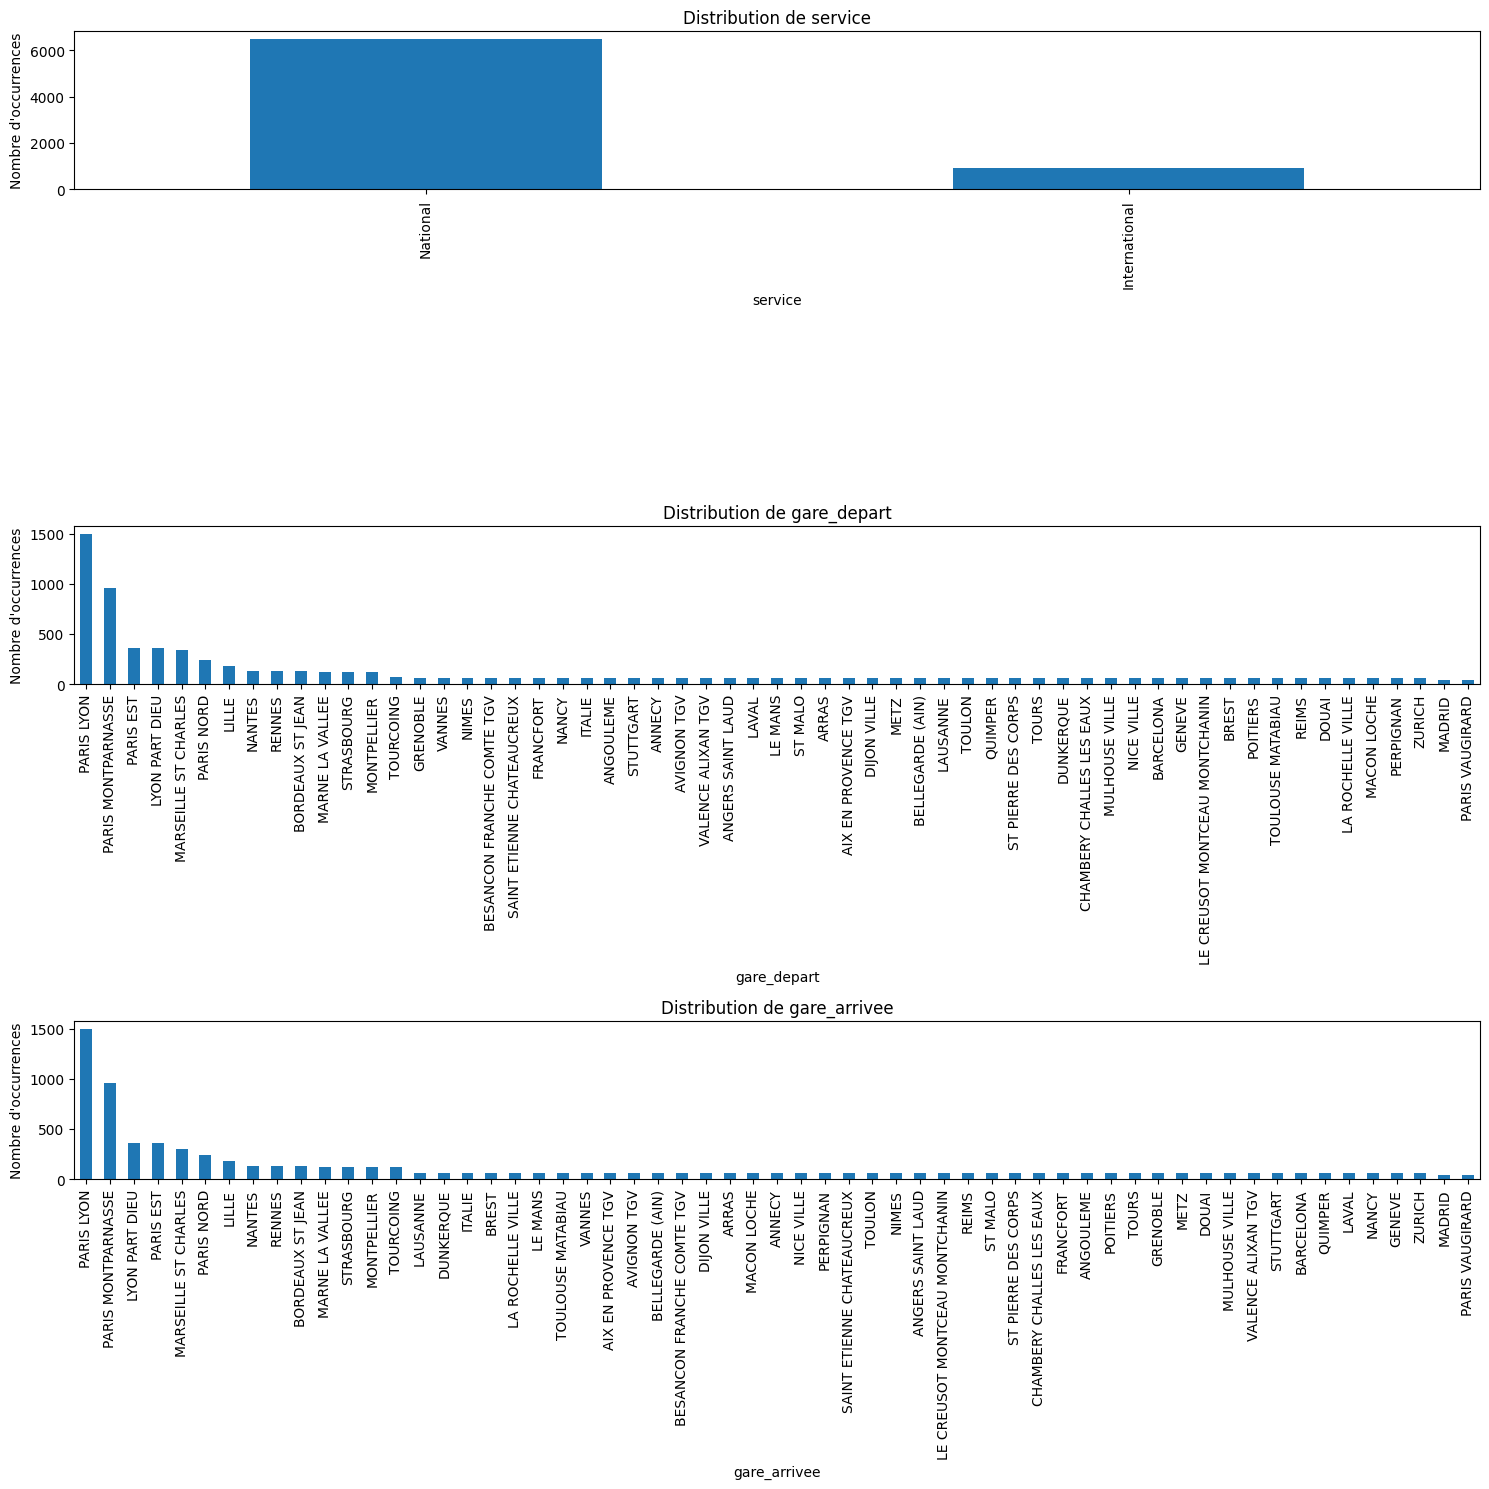

In [9]:
# Créer un graphique avec 3 sous-graphiques (1 par catégorie)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# Parcourir les variables catégorielles et créer un graphique pour chaque
for i, cat in enumerate(['service','gare_depart','gare_arrivee']):
    ax = axes[i]
    count = data_train[cat].value_counts()
    count.plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution de {cat}')
    ax.set_xlabel(f'{cat}')
    ax.set_ylabel('Nombre d\'occurrences')

# Régler l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique avec les sous-graphiques
plt.show()


- On voit clairement que certaines catégories sont sur-représentées. Par exemple la majorité des trains sont nationaux et la plupart partent de Paris Lyon ou Paris Montparnasse.
- Dans le cas du service il sera intéressant de regarder la corrélation avec le nombre de retard, il se peut que cette variable ne soit pas pertinente.
- comme les modèles ont tendance à avoir de meilleurs performances sur les classes majoritaires, on pourra envisager l'utilisation de l'oversampling pour compenser ce manque d'équilibre dans les catégories

## Analyse bidimensionnelle <a class="anchor" id="analyse-bidimensionnelle"></a>
[Up](#table-des-matieres)

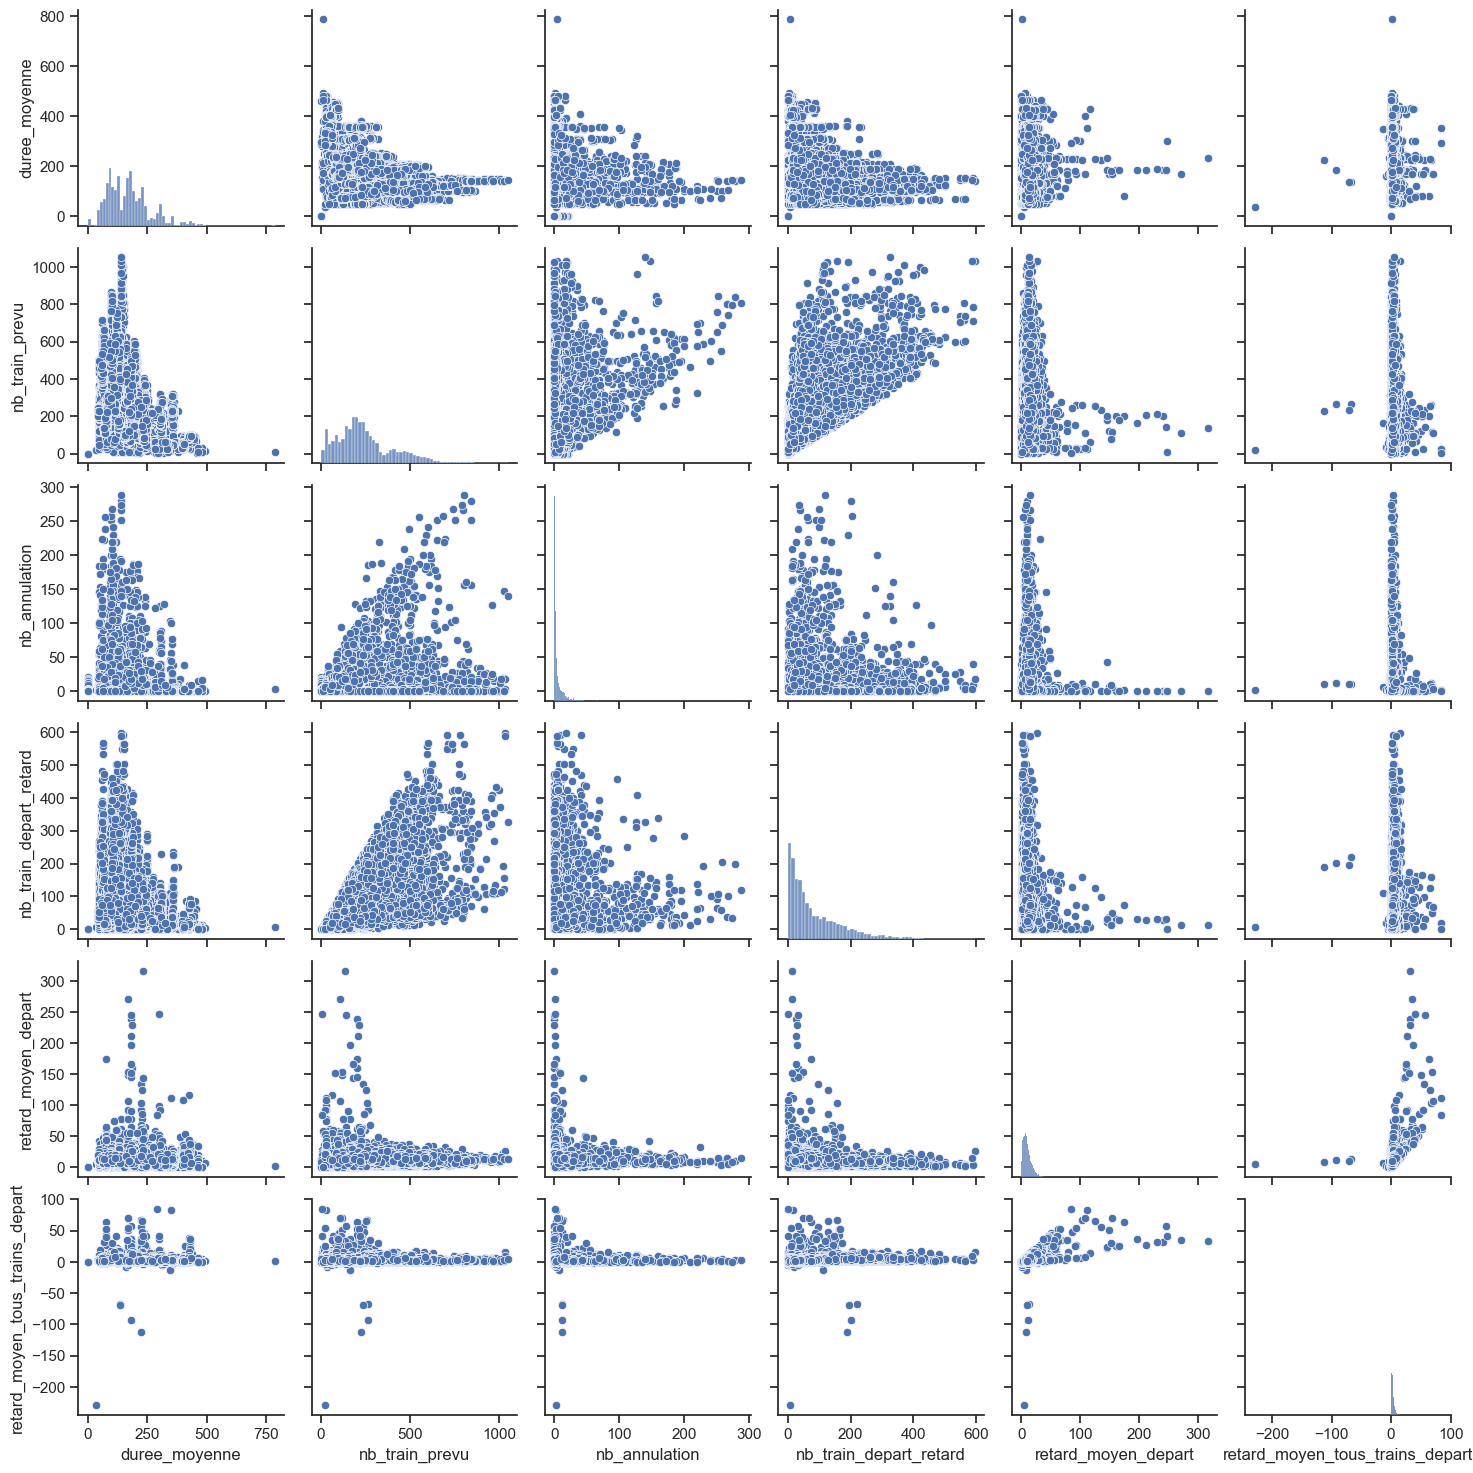

In [10]:
sns.set_theme(style="ticks")

sns.pairplot(data_train[['service', 'gare_depart', 'gare_arrivee','duree_moyenne', 'nb_train_prevu', 'nb_annulation','nb_train_depart_retard', 'retard_moyen_depart','retard_moyen_tous_trains_depart']])

- Il semble pertinent de ne pas garder les valeurs négatives pour les retards moyens tous trains départ  
- De même pour les valeurs moyenne retard arrivée

In [11]:
data_train_2 = data_train.copy()
data_train_2 = data_train_2.drop('date',axis=1)

label_encoder = LabelEncoder()

data_train_2['service'] = label_encoder.fit_transform(data_train_2['service'])
data_train_2['gare_depart'] = label_encoder.fit_transform(data_train_2['gare_depart'])
data_train_2['gare_arrivee'] = label_encoder.fit_transform(data_train_2['gare_arrivee'])

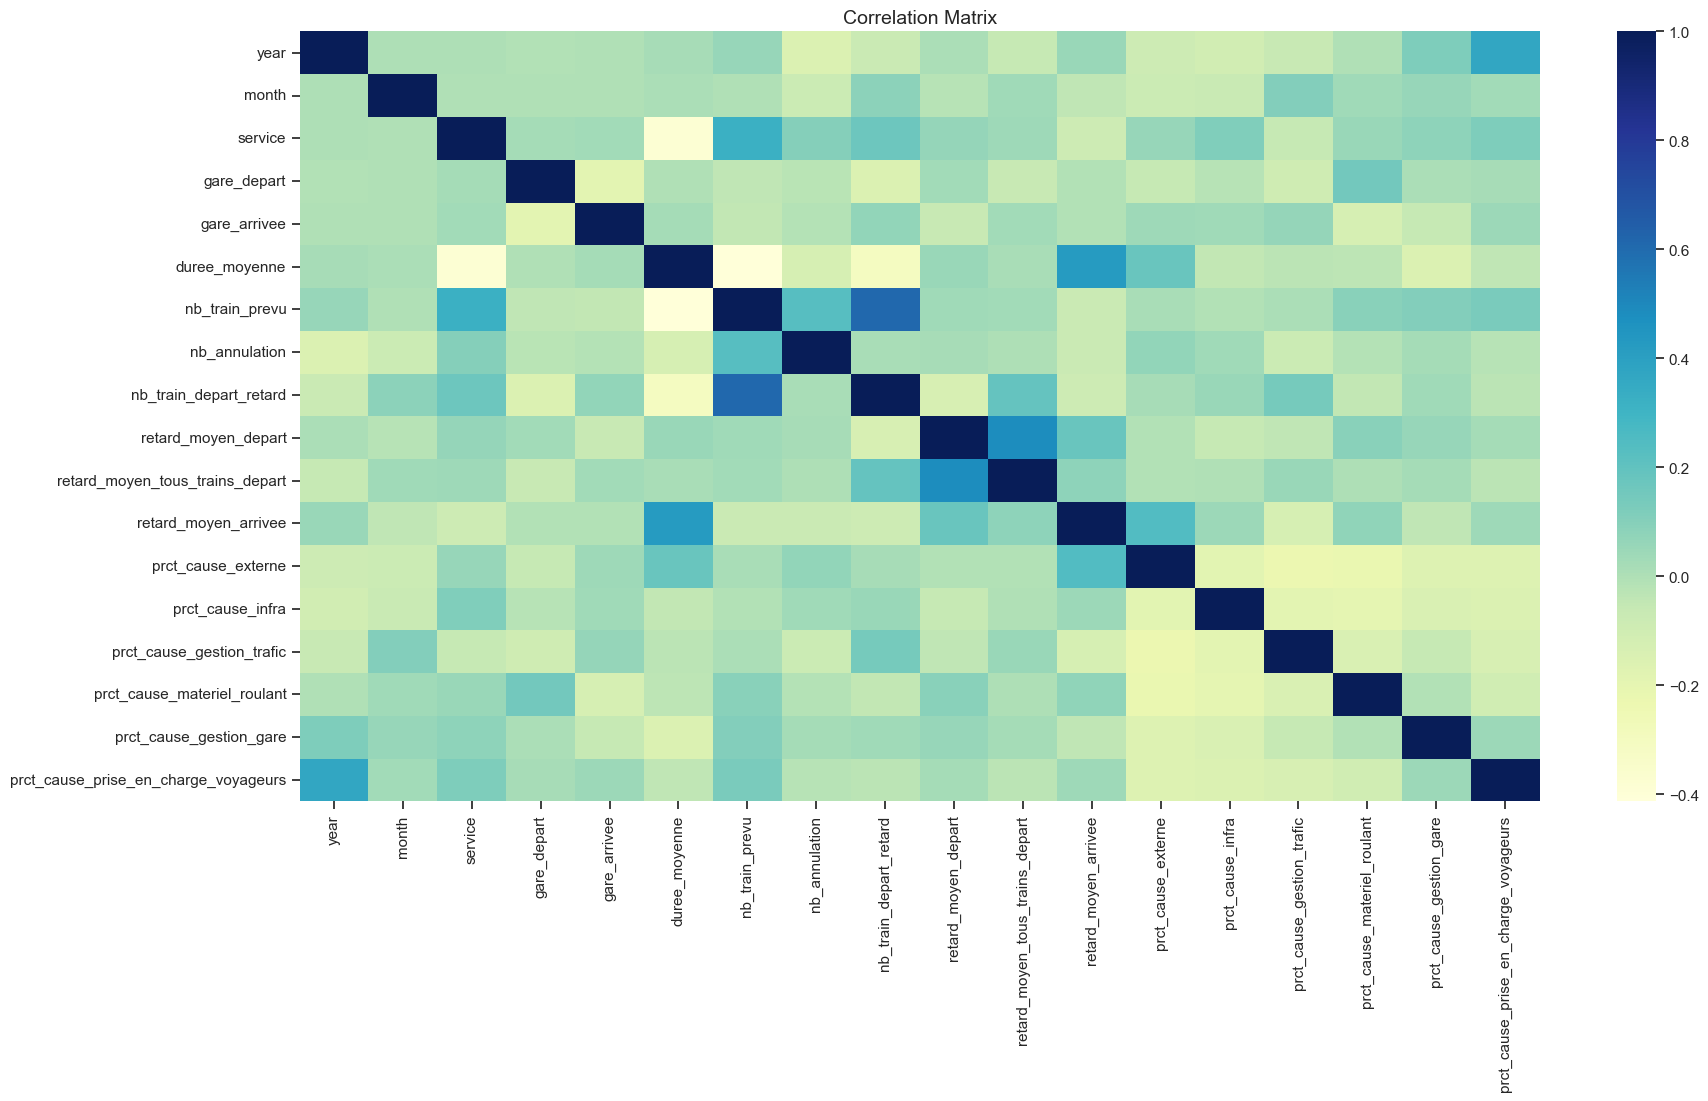

In [12]:
fig, ax = plt.subplots(figsize=(20,10))         

corr = data_train_2.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Correlation Matrix", fontsize=14)
plt.show()

On voit une forte corrélation entre le retard moyen départ et le retard moyen tous trains depart on pourra envisager de ne pas garder cette variable si on a besoin d'indépandance entre le colonnes (modèle bayésien)

## PCA

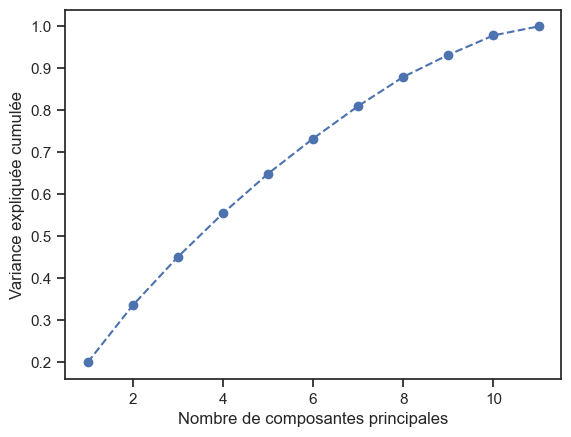

In [13]:
X_train = data_train_2[['year','month','service','gare_depart','gare_arrivee','duree_moyenne','nb_train_prevu','nb_annulation','nb_train_depart_retard','retard_moyen_depart','retard_moyen_tous_trains_depart']]
SC=StandardScaler()
SC.fit(X_train)
X_train_scaled = SC.transform(X_train)

pca = PCA()
pca.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.show()


In [14]:
pca = PCA(n_components=3)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

C:\Users\natha\AppData\Local\Temp\ipykernel_20372\3728020356.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], cmap='viridis', s=10, edgecolor='k', linewidth=0.2)


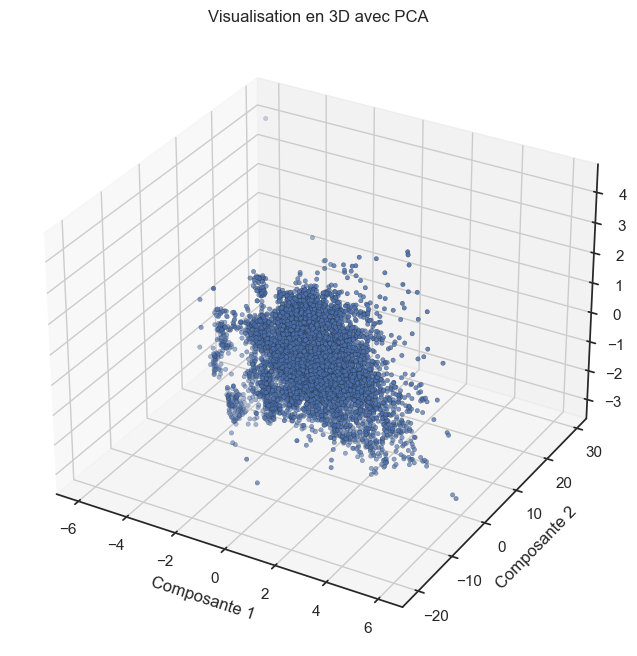

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], cmap='viridis', s=10, edgecolor='k', linewidth=0.2)

ax.set_xlabel('Composante 1')
ax.set_ylabel('Composante 2')
ax.set_zlabel('Composante 3')
ax.set_title('Visualisation en 3D avec PCA')

plt.show()

On ne reconnait pas de motifs particuliers

## Analyse temporelle <a class="anchor" id="analyse-temporelle"></a>
[Up](#table-des-matieres)

On reprend le jeu data_train pour visualiser des périodicités sur les variables numériques

In [16]:
data_time = data_train[['date','service','gare_depart','gare_arrivee','duree_moyenne', 'nb_train_prevu', 'nb_annulation','nb_train_depart_retard', 'retard_moyen_depart']]

In [17]:
colonnes_numeriques = data_time.select_dtypes(include=['float64', 'int64'])
data_agregee = data_time.groupby('date')[colonnes_numeriques.columns].mean()
data_agregee = data_agregee.reset_index()
data_agregee['year'] = data_agregee['date'].dt.year # extrait l'année
data_agregee['month'] = data_agregee['date'].dt.month # extrait le mois
data_agregee = data_agregee[data_agregee['year'] != 2020]


<AxesSubplot: xlabel='month', ylabel='duree_moyenne'>

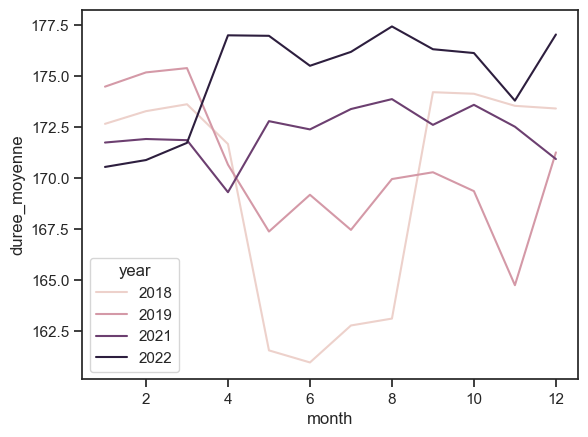

In [18]:
sns.lineplot(data=data_agregee, x='month', y="duree_moyenne", hue='year')

<AxesSubplot: xlabel='month', ylabel='nb_train_prevu'>

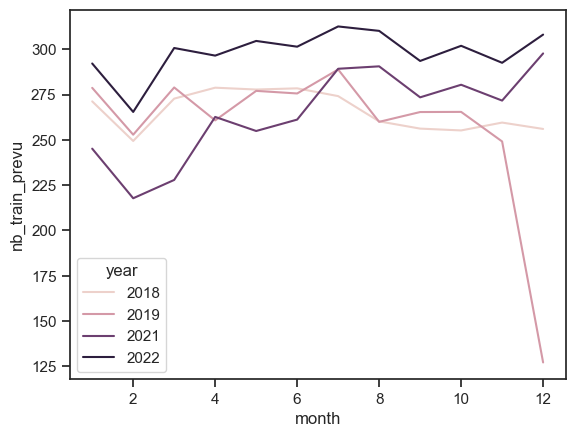

In [19]:
sns.lineplot(data=data_agregee, x='month', y="nb_train_prevu", hue='year')

<AxesSubplot: xlabel='month', ylabel='nb_annulation'>

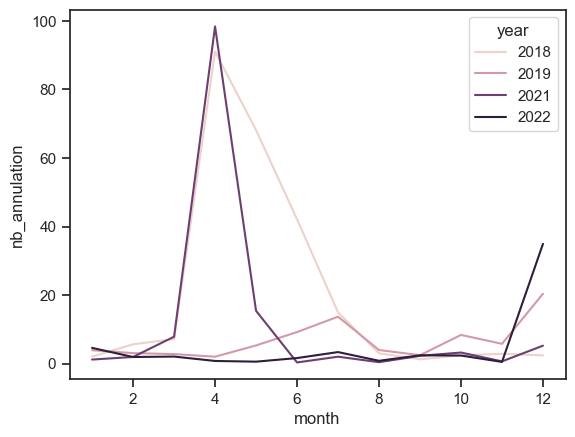

In [20]:
sns.lineplot(data=data_agregee, x='month', y="nb_annulation", hue='year')

<AxesSubplot: xlabel='month', ylabel='nb_train_depart_retard'>

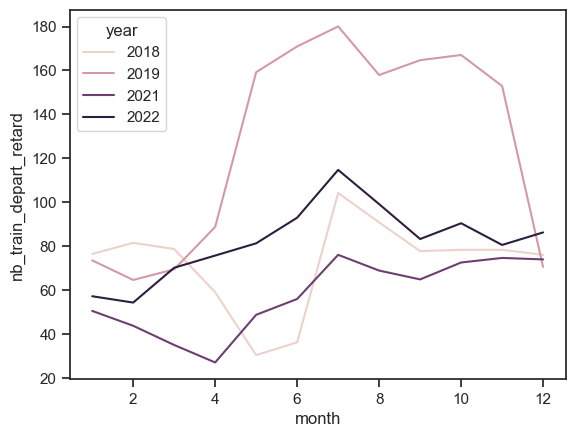

In [21]:
sns.lineplot(data=data_agregee, x='month', y="nb_train_depart_retard", hue='year')

<AxesSubplot: xlabel='month', ylabel='retard_moyen_depart'>

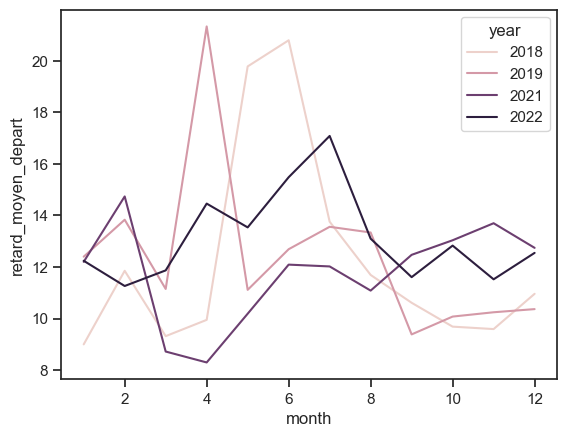

In [22]:
sns.lineplot(data=data_agregee, x='month', y="retard_moyen_depart", hue='year')

l'analyse temporelle encourage à écarter les données de 2020 du train set. 
On ne voit pas pas d'informations particulières ressortir si ce n'est une saisonnalité du nombre de train prévu (été et Noël)




## Prediction retard moyen arrivee <a class="anchor" id="prediction-retard-moyen-arrivee"></a>

### Definition des fonctions de preprocessing <a class="anchor" id="definition-des-fonctions-de-preprocessing"></a>
[Up](#table-des-matieres)

In [23]:
def loading(colonnes_x = ['year','month','service','gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu', 'retard_moyen_depart','nb_annulation','nb_train_depart_retard','retard_moyen_tous_trains_depart'], colonne_y = ['retard_moyen_arrivee'], t_size = 0.2, validation = True,covid_et_negativ = True):
    # Chargement des données et transformation des dates
    data = pd.read_csv('regularite-mensuelle-tgv-aqst.csv', sep=";")
    data['year'] = pd.to_datetime(data['date'], format="%Y-%m").dt.year
    data['month'] = pd.to_datetime(data['date'], format="%Y-%m").dt.month
    data.drop('date', axis=1, inplace=True)

    # Encodage des variables catégorielles
    label_encoder = LabelEncoder()
    data['service'] = label_encoder.fit_transform(data['service'])
    data['gare_depart'] = label_encoder.fit_transform(data['gare_depart'])
    data['gare_arrivee'] = label_encoder.fit_transform(data['gare_arrivee'])

    # Filtrage des données pour l'entraînement et la test
    if covid_et_negativ is False :
        data_train = data[(data['year'] != 2023) & (data['year'] != 2020) & (data['retard_moyen_arrivee'] >= 0)]
    else:
        data_train = data[data['year'] != 2023]
    data_test = data[data['year'] == 2023]

    # Sans validation set
    if validation is False :
        X, y = data_train[colonnes_x], data_train[colonne_y]
        X_test, y_test = data_test[colonnes_x], data_test[colonne_y]
        return X, X_test, y, y_test
    
    else :
        X, y = data_train[colonnes_x], data_train[colonne_y]
        X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size=0.2,random_state=42)
        X_test, y_test = data_test[colonnes_x], data_test[colonne_y]
        return X_train, X_validation, X_test, y_train, y_validation, y_test

def linear_model(X,X_test,y,y_test):
    scaler = StandardScaler()
    modele = LinearRegression()

    pipeline = Pipeline([
        ('scaling',scaler),
        ('modele',modele)
    ])

    pipeline.fit(X,y)

    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return [mse,r2]

### Regression lineaire <a class="anchor" id="regression-lineaire"></a>

#### Sur tout le jeu de donnees <a class="anchor" id="sur-tout-le-de-donnees"></a>
[Up](#table-des-matieres)

In [24]:
X, X_test, y, y_test = loading(validation=False)

scaler = StandardScaler()
modele = LinearRegression()

pipeline = Pipeline([
    ("mise à l'échelle", scaler),
    ("choix du modèle", modele),
])

pipeline.fit(X,y)
y_pred_test = pipeline.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"mse_test: {mse_test}\n r2_test: {r2_test}")

mse_test: 285.9329234476706
 r2_test: 0.1988394824515537


#### Meilleur choix de colonnes <a class="anchor" id="meilleur-choix-de-colonnes"></a>
[Up](#table-des-matieres)

In [25]:
# Exemple de liste de noms de colonnes
col_names = ['year','month','service','gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu', 'retard_moyen_depart','nb_annulation','nb_train_depart_retard','retard_moyen_tous_trains_depart']

# Génération de tous les couples de colonnes possibles
pairs = []
for i in range(2,len(col_names)):
    pairs += [list(pair) for pair in combinations(col_names, i+1)]

dico ={}

for pair in pairs:
    X, X_validation, X_test, y, y_validation, y_test = loading(colonnes_x=pair)
    perf = linear_model(X,X_validation,y,y_validation)
    dico[str(pair)]=perf

X,X_test,y,y_test = loading(colonnes_x=['year','month', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_tous_trains_depart'],validation=False)

print(linear_model(X,X_test,y,y_test))

[280.8249264205099, 0.21315166970362764]


#### Relations polynomiales entre les colonnes <a class="anchor" id="relations-polynomiales-entre-les-colonnes"></a>
[Up](#table-des-matieres)

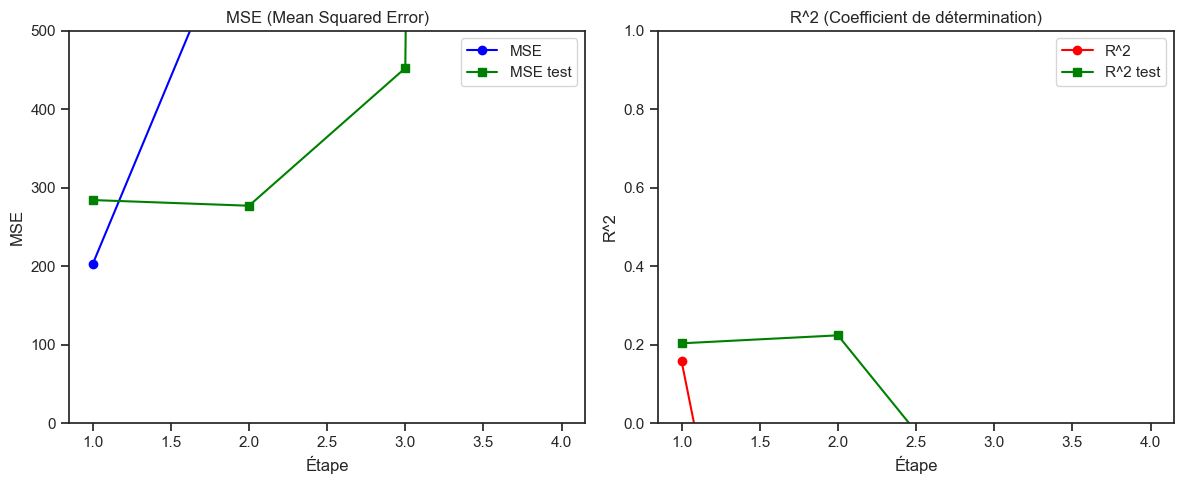

In [26]:
# Validation
X,X_validation,X_test,y,y_validation,y_test = loading(colonnes_x=['year','month', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_tous_trains_depart'])

MSE = []
R2 = []

MSE_test = []
R2_test = []
N = [i for i in range(1,5)]

for n in N:
    scaler = StandardScaler()
    polynomial = PolynomialFeatures(degree=n)
    modele = LinearRegression()

    pipeline = Pipeline([
        ("mise à l'échelle", scaler),
        ("relations polynomiales entre les colonnes",polynomial),
        ("choix du modèle", modele),
    ])

    pipeline.fit(X,y)
    y_pred = pipeline.predict(X_validation)
    MSE.append(mean_squared_error(y_validation,y_pred))
    R2.append(r2_score(y_validation,y_pred))

    y_pred = pipeline.predict(X_test)
    MSE_test.append(mean_squared_error(y_test,y_pred))
    R2_test.append(r2_score(y_test,y_pred))

# Création des subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Tracer le MSE
ax[0].plot(N, MSE, '-o', color='blue', label='MSE')
ax[0].plot(N, MSE_test, '-s', color='green', label='MSE test')
ax[0].set_title('MSE (Mean Squared Error)')
ax[0].set_xlabel('Étape')
ax[0].set_ylabel('MSE')
ax[0].set_ylim(0, 500)
ax[0].legend()

# Tracer le R^2
ax[1].plot(N, R2, '-o', color='red', label='R^2')
ax[1].plot(N, R2_test, '-s', color='green', label='R^2 test')
ax[1].set_title('R^2 (Coefficient de détermination)')
ax[1].set_xlabel('Étape')
ax[1].set_ylabel('R^2')
ax[1].set_ylim(0, 1)
ax[1].legend()

# Affichage des courbes
plt.tight_layout()
plt.show()

In [27]:
# Test
X,X_test,y,y_test = loading(colonnes_x=['year','month', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_tous_trains_depart'],validation=False)

scaler = StandardScaler()
polynomial = PolynomialFeatures(degree=2)
modele = LinearRegression()

pipeline = Pipeline([
    ("mise à l'échelle", scaler),
    ("relations polynomiales entre les colonnes",polynomial),
    ("choix du modèle", modele),
])

pipeline.fit(X,y)
y_pred = pipeline.predict(X_test)
mse = (mean_squared_error(y_test,y_pred))
r2 = (r2_score(y_test,y_pred))

print(mse,r2)

272.9633829748657 0.23517906738731764


#### Avec PCA <a class="anchor" id="avec-pca"></a>
[Up](#table-des-matieres)

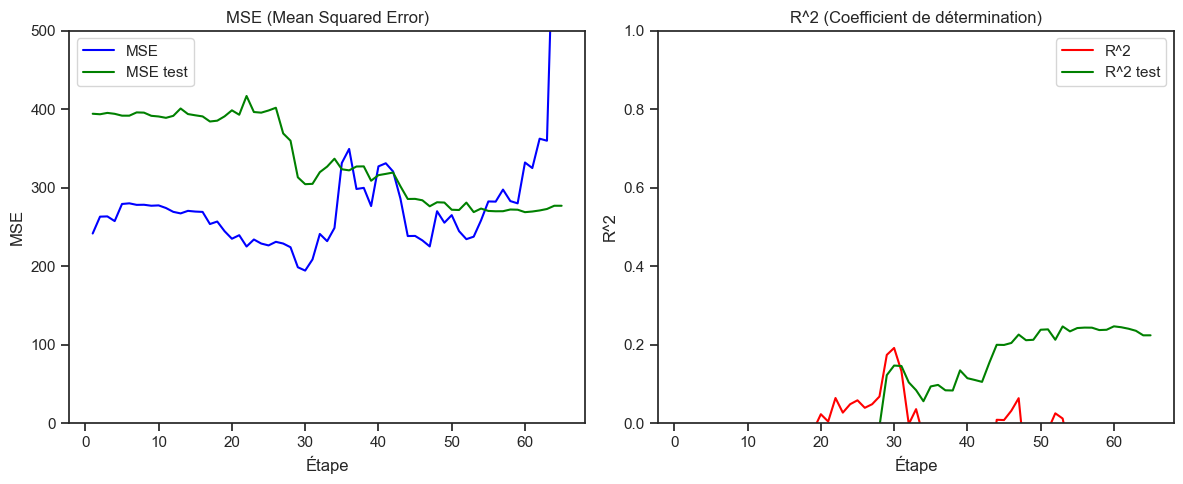

In [28]:
X,X_validation,X_test,y,y_validation,y_test = loading(colonnes_x=['year','month', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_tous_trains_depart'])

MSE = []
R2 = []

MSE_test = []
R2_test = []
N = [i for i in range(1,66)]

for n in N:
    scaler = StandardScaler()
    polynomial = PolynomialFeatures(degree=2)
    pca = PCA(n_components=n)
    modele = LinearRegression()

    pipeline = Pipeline([
        ("mise à l'échelle", scaler),
        ("relations polynomiales entre les colonnes",polynomial),
        ("Changement de repère",pca),
        ("choix du modèle", modele),
    ])

    pipeline.fit(X,y)
    y_pred = pipeline.predict(X_validation)
    MSE.append(mean_squared_error(y_validation,y_pred))
    R2.append(r2_score(y_validation,y_pred))

    y_pred = pipeline.predict(X_test)
    MSE_test.append(mean_squared_error(y_test,y_pred))
    R2_test.append(r2_score(y_test,y_pred))


# Création des subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Tracer le MSE
ax[0].plot(N, MSE, '-', color='blue', label='MSE')
ax[0].plot(N, MSE_test, '-', color='green', label='MSE test')
ax[0].set_title('MSE (Mean Squared Error)')
ax[0].set_xlabel('Étape')
ax[0].set_ylabel('MSE')
ax[0].set_ylim(0, 500)
ax[0].legend()

# Tracer le R^2
ax[1].plot(N, R2, '-', color='red', label='R^2')
ax[1].plot(N, R2_test, '-', color='green', label='R^2 test')
ax[1].set_title('R^2 (Coefficient de détermination)')
ax[1].set_xlabel('Étape')
ax[1].set_ylabel('R^2')
ax[1].set_ylim(0, 1)
ax[1].legend()

# Affichage des courbes
plt.tight_layout()
plt.show()

### Modele lineaire <a class="anchor" id="modele-lineaire"></a>

#### Ridge <a class="anchor" id="ridge"></a>
[Up](#table-des-matieres)

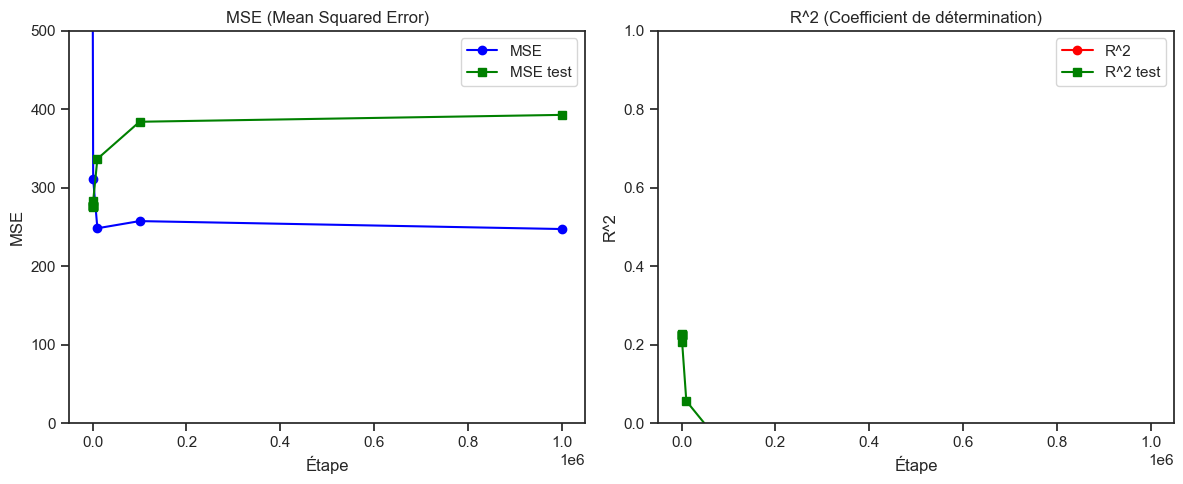

[277.0448092498977, 277.0445847871839, 277.04234184699413, 277.02008028675334, 276.81343621263767, 275.8038249263068, 282.9487957996222, 336.81605942499465, 384.10409252514205, 392.86361115967816]
[0.2237432468899312, 0.22374387581598065, 0.22375016034978534, 0.22381253540932344, 0.22439153509697973, 0.22722038282436496, 0.2072007625102268, 0.05626912342278123, -0.07622805324213555, -0.10077150349649067]


In [29]:
X,X_validation,X_test,y,y_validation,y_test = loading(colonnes_x=['year','month', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_tous_trains_depart'])

MSE = []
R2 = []

MSE_test = []
R2_test = []
N = [10**(-3+i) for i in range(10)]

for n in N:
    scaler = StandardScaler()
    polynomial = PolynomialFeatures(degree=2)
    modele = Ridge(alpha=n)

    pipeline = Pipeline([
        ("mise à l'échelle", scaler),
        ("relations polynomiales entre les colonnes",polynomial),
        ("choix du modèle", modele),
    ])

    pipeline.fit(X,y)
    y_pred = pipeline.predict(X_validation)
    MSE.append(mean_squared_error(y_validation,y_pred))
    R2.append(r2_score(y_validation,y_pred))

    y_pred = pipeline.predict(X_test)
    MSE_test.append(mean_squared_error(y_test,y_pred))
    R2_test.append(r2_score(y_test,y_pred))


# Création des subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Tracer le MSE
ax[0].plot(N, MSE, 'o-', color='blue', label='MSE')
ax[0].plot(N, MSE_test, 's-', color='green', label='MSE test')
ax[0].set_title('MSE (Mean Squared Error)')
ax[0].set_xlabel('Étape')
ax[0].set_ylabel('MSE')
ax[0].set_ylim(0, 500)
ax[0].legend()

# Tracer le R^2
ax[1].plot(N, R2, 'o-', color='red', label='R^2')
ax[1].plot(N, R2_test, 's-', color='green', label='R^2 test')
ax[1].set_title('R^2 (Coefficient de détermination)')
ax[1].set_xlabel('Étape')
ax[1].set_ylabel('R^2')
ax[1].set_ylim(0, 1)
ax[1].legend()

# Affichage des courbes
plt.tight_layout()
plt.show()

print(MSE_test)
print(R2_test)

#### Lasso <a class="anchor" id="lasso"></a>
[Up](#table-des-matieres)

In [30]:
X,X_test,y,y_test = loading(colonnes_x=['year','month', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_tous_trains_depart'],validation=False)

scaler = StandardScaler()
polynomial = PolynomialFeatures(degree=2)
modele = LassoCV()

pipeline = Pipeline([
    ("mise à l'échelle", scaler),
    ("relations polynomiales entre les colonnes",polynomial),
    ("choix du modèle", modele),
])

pipeline.fit(X,y)

y_pred = pipeline.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred)
r2_test = r2_score(y_test,y_pred)

print(mse_test)
print(r2_test)


269.35581063019697
0.24528718817277584


c:\Users\natha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Elastic Net <a class="anchor" id="elasctic-net"></a>
[Up](#table-des-matieres)

In [31]:
X,X_test,y,y_test = loading(colonnes_x=['year','month', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_tous_trains_depart'],validation=False)

scaler = StandardScaler()
polynomial = PolynomialFeatures(degree=2)
modele = ElasticNetCV()

pipeline = Pipeline([
    ("mise à l'échelle", scaler),
    ("relations polynomiales entre les colonnes",polynomial),
    ("choix du modèle", modele),
])

pipeline.fit(X,y)

y_pred = pipeline.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred)
r2_test = r2_score(y_test,y_pred)

print(mse_test)
print(r2_test)


278.1008173890198
0.2207843989997571


c:\Users\natha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
X_train, X_validation, X_test, y_train, y_validation, y_test = loading(colonnes_x=['year', 'month', 'service', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_train_depart_retard'])

scaler = StandardScaler()
for l1 in [1e-6,0.1,0.5,1]:
    print(l1)
    modele = ElasticNetCV(l1_ratio=l1, random_state=42)

    pipeline = Pipeline([
        ('scaling',scaler),
        ('modele',modele)
    ])

    pipeline.fit(X_train,y_train)

    y_pred_validation = pipeline.predict(X_validation)
    mse_validation = mean_squared_error(y_validation, y_pred_validation)
    r2_validation = r2_score(y_validation, y_pred_validation)

    y_pred_test = pipeline.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    print(f"mse_validation: {mse_validation}\n r2_validation: {r2_validation}\n mse_test: {mse_test}\n r2_test: {r2_test}")

1e-06
mse_validation: 240.4570267758585
 r2_validation: -4.877469008057744e-05
 mse_test: 393.9578902629775
 r2_test: -0.10383758347836514
0.1
mse_validation: 197.24004194856278
 r2_validation: 0.17968850852362017
 mse_test: 282.94788871189377
 r2_test: 0.20720330409538312
0.5
mse_validation: 197.50410132758168
 r2_validation: 0.17859029874379362
 mse_test: 279.71194622737033
 r2_test: 0.21627014860002536
1


c:\Users\natha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d

mse_validation: 197.582888332364
 r2_validation: 0.17826262752265887
 mse_test: 279.47646969879094
 r2_test: 0.21692993445200925


#### Bayesian Ridge <a class="anchor" id="bayesien-ridge"></a>
[Up](#table-des-matieres)

In [33]:
X_train, X_validation, X_test, y_train, y_validation, y_test = loading(colonnes_x=['year', 'month', 'service', 'gare_arrivee', 'duree_moyenne', 'retard_moyen_depart', 'nb_train_depart_retard'])

scaler = StandardScaler()
modele = BayesianRidge()

pipeline = Pipeline([
    ('scaling',scaler),
    ('modele',modele)
])

pipeline.fit(X_train,y_train)

y_pred_validation = pipeline.predict(X_validation)
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)

y_pred_test = pipeline.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"mse_validation: {mse_validation}\n r2_validation: {r2_validation}\n mse_test: {mse_test}\n r2_test: {r2_test}")

mse_validation: 197.53852298449323
 r2_validation: 0.17844714079046298
 mse_test: 279.17308827706216
 r2_test: 0.21777998422562805


c:\Users\natha\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Decision trees and random forest <a class="anchor" id="decision-trees-and-random-forest"></a>
#### Decision Tree <a class="anchor" id="Decision_Tree"></a>
[Up](#table-des-matieres)

In [53]:
X_train, X_test, y_train, y_test = loading(validation=False)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train_scaled, y_train)
y_pred_test = dtr.predict(X_test_scaled)
print(r2_score(y_test,y_pred_test))
print(mean_squared_error(y_test,y_pred_test))

-0.0555181193896741
376.7127498402049


#### Random Forest <a class="anchor" id="Random_Forest"></a>
[Up](#table-des-matieres)

In [41]:
import multiprocessing
from joblib import Parallel,delayed
from sklearn.model_selection import cross_val_score

In [59]:
X_train, X_test, y_train, y_test = loading(validation=False)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [76]:
grid_search=[]
num_cores = multiprocessing.cpu_count()

def rforest(n_est,m_dep,min_split,boot):
    rd_for = RandomForestRegressor(n_estimators=n_est,max_depth=m_dep,min_samples_split=min_split,bootstrap=boot,random_state=42)
    scores=cross_val_score(rd_for, X_train_scaled, y_train, cv=5)
    grid_search.append([n_est,m_dep,min_split,boot,scores.mean(),scores.std()])


param_grid=[]
x=[600,700,800]
y=[10]
z=[2,5,10]
bootstr=[True]
for xi in x:
    for yi in y:
        for zi in z:
            for boot in bootstr:         
                param_grid.append([xi,yi,zi,boot])


Parallel(n_jobs=num_cores,backend='threading')(delayed(rforest)(param[0],param[1],param[2],param[3]) for param in param_grid)

c:\Users\natha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

[None, None, None, None, None, None, None, None, None]

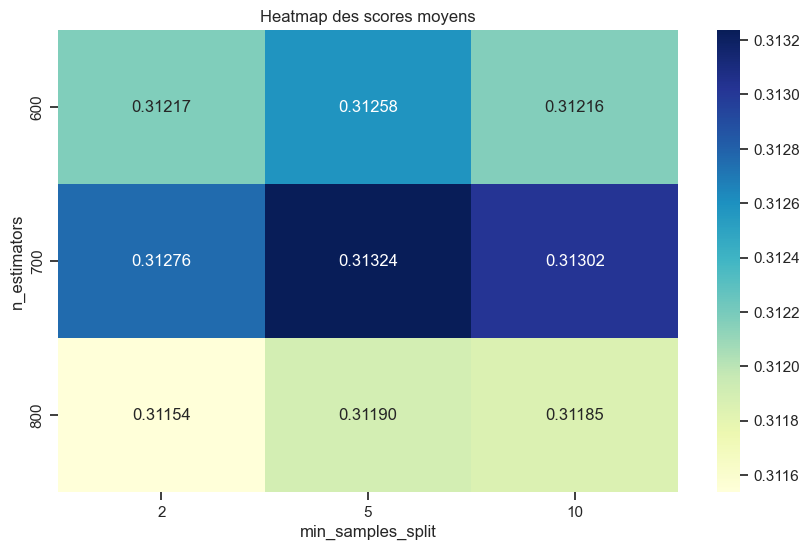

In [77]:
df = pd.DataFrame(grid_search, columns=["n_estimators", "max_depth","min_samples_split","bootstrap","mean_score","std_score"])

# Pivoter les données pour créer la heatmap
heatmap_data = df.pivot("n_estimators", "min_samples_split", "mean_score")

# Afficher la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".5f", cmap="YlGnBu")
plt.xlabel("min_samples_split")
plt.ylabel("n_estimators")
plt.title("Heatmap des scores moyens")
plt.show()

In [78]:
rd_for = RandomForestRegressor(n_estimators=700,max_depth=10,min_samples_split=5,bootstrap=True,random_state=42)
rd_for.fit(X_train_scaled, y_train)
y_pred_test = rd_for.predict(X_test_scaled)
print(r2_score(y_test,y_pred_test))
print(mean_squared_error(y_test,y_pred_test))

C:\Users\natha\AppData\Local\Temp\ipykernel_17572\2444700431.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rd_for.fit(X_train_scaled, y_train)


0.2626699707473439
263.15192298180085


Text(0, 0.5, 'FEATURE NAMES')

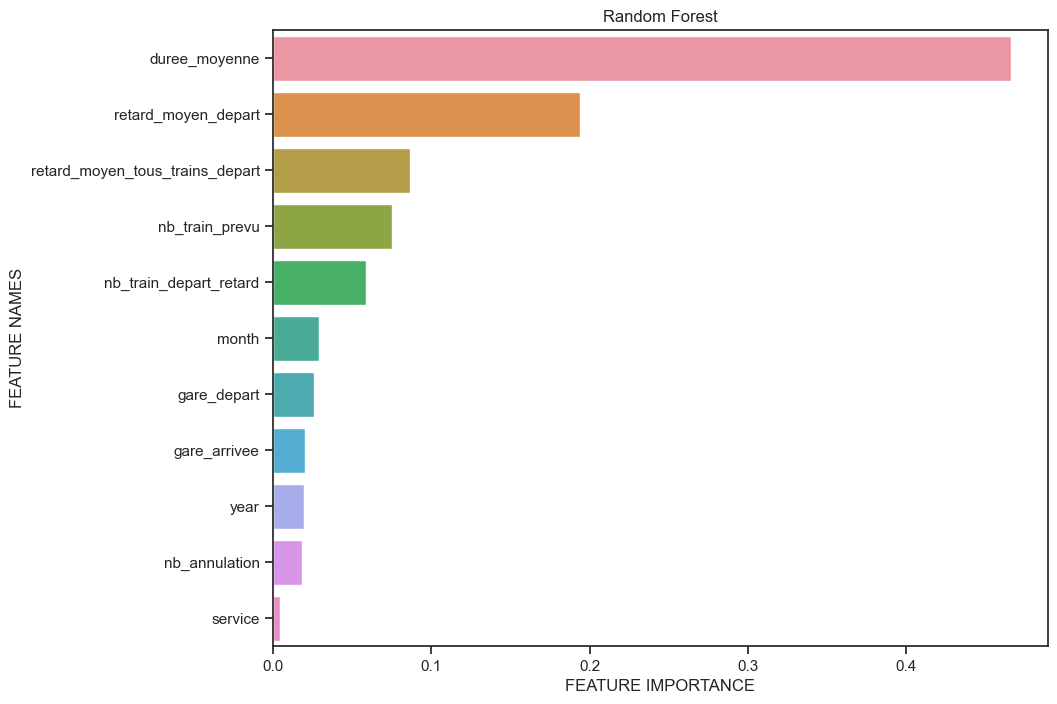

In [79]:
importance=rd_for.feature_importances_
names=['year','month','service','gare_depart', 'gare_arrivee', 'duree_moyenne', 'nb_train_prevu', 'retard_moyen_depart','nb_annulation','nb_train_depart_retard','retard_moyen_tous_trains_depart']

#Create arrays from feature importance and feature names
feature_importance = np.array(importance)
feature_names = np.array(names)

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
plt.title( 'Random Forest')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

#### Adabbost <a class="anchor" id="Adaboost"></a>
[Up](#table-des-matieres)

In [56]:
grid_search_adaboost=[]
num_cores = multiprocessing.cpu_count()

X_train, X_test, y_train, y_test = loading(validation=False)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


def ad_boost(n_est,l_rate):
    adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0,max_depth=10),random_state=0,n_estimators=n_est,learning_rate=l_rate)
    scores=cross_val_score(adaboost, X_train_scaled, y_train, cv=5)
    grid_search_adaboost.append([n_est,l_rate,scores.mean(),scores.std()])


param_grid_adaboost=[]
x=[10,25,50,100]
y=[0.1,0.25,0.5,1]

for xi in x:
    for yi in y:     
        param_grid_adaboost.append([xi,yi])


Parallel(n_jobs=num_cores,backend='threading')(delayed(ad_boost)(param[0],param[1]) for param in param_grid_adaboost)

c:\Users\natha\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\natha\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

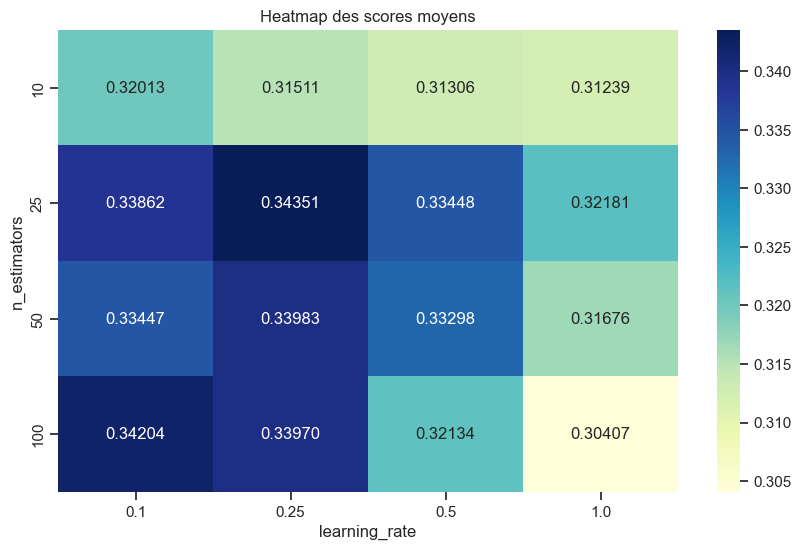

In [57]:
df = pd.DataFrame(grid_search_adaboost, columns=["n_estimators", "learning_rate","mean_score","std_score"])

# Pivoter les données pour créer la heatmap
heatmap_data = df.pivot("n_estimators", "learning_rate", "mean_score")

# Afficher la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".5f", cmap="YlGnBu")
plt.xlabel("learning_rate")
plt.ylabel("n_estimators")
plt.title("Heatmap des scores moyens")
plt.show()

In [58]:
adb = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0,max_depth=10),random_state=0,n_estimators=25,learning_rate=0.25)
adb.fit(X_train_scaled, y_train)
y_pred_test = adb.predict(X_test_scaled)
print(r2_score(y_test,y_pred_test))
print(mean_squared_error(y_test,y_pred_test))

c:\Users\natha\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2505358996899111
267.4825537789728


## Prediction raison retard <a class="anchor" id="prediction-raison-retard"></a>

### Linear regression <a class="anchor" id="linear-regression"></a>
[Up](#table-des-matieres)

In [81]:
causes=['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic','prct_cause_materiel_roulant', 'prct_cause_gestion_gare','prct_cause_prise_en_charge_voyageurs']

X_train, X_test, y_train, y_test = loading(validation=False,colonne_y=causes)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


for x in causes:
    rd_for = LinearRegression()
    rd_for.fit(X_train_scaled, y_train[x])
    y_pred_test = rd_for.predict(X_test_scaled)
    print(x,r2_score(y_test[x],y_pred_test),mean_squared_error(y_test[x],y_pred_test))

prct_cause_externe 0.06539693597661134 177.9135200948504
prct_cause_infra -0.008317624598398687 162.90396549483037
prct_cause_gestion_trafic -0.08025733836547744 247.97401681617157
prct_cause_materiel_roulant 0.025563905010847487 164.22430156204422
prct_cause_gestion_gare 0.0887408185517512 56.241751737389336
prct_cause_prise_en_charge_voyageurs -0.5623252582281404 106.40505976648845


### Random forest <a class="anchor" id="random-forest"></a>
[Up](#table-des-matieres)

In [82]:
causes=['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic','prct_cause_materiel_roulant', 'prct_cause_gestion_gare','prct_cause_prise_en_charge_voyageurs']

X_train, X_test, y_train, y_test = loading(validation=False,colonne_y=causes)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)


for x in causes:
    rd_for = RandomForestRegressor(random_state=42)
    rd_for.fit(X_train_scaled, y_train[x])
    y_pred_test = rd_for.predict(X_test_scaled)
    print(x,r2_score(y_test[x],y_pred_test),mean_squared_error(y_test[x],y_pred_test))

prct_cause_externe 0.10342682680023807 170.6740491304315
prct_cause_infra 0.003976576735755133 160.91771225372176
prct_cause_gestion_trafic 0.3224248172407981 155.53797581045012
prct_cause_materiel_roulant 0.06817349697036401 157.04319392925152
prct_cause_gestion_gare 0.18988201318975695 49.99944650188731
prct_cause_prise_en_charge_voyageurs -0.22482051199637354 83.4186729657058
